In [57]:
import pandas as pd
import numpy as np
import math
import time
import tqdm
import os
from scipy.optimize import minimize
import astropy.constants as const
from astropy import units as u
import rebound

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':20})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

folders = ['results', 'plots']
for ff in folders:
    if not os.path.exists(ff):
        os.mkdir(ff)

**Problem 1:** Install the dynamical integrator REBOUND using Python: https://
rebound.readthedocs.io/en/latest/ Look through the example notebooks, and
familiarize yourself with initializing and running a planetary system.

**Problem 2:** Look up the parameters of the planet system GJ 876. Assume the planets’ orbits
lie in a plane, and vary the inclination of the system. At what inclination does the
system become unstable after 1000 orbits of the inner planet? What upper limit
does this place on the planets’ masses? At what inclination would the planets be
seen to transit? What lower limit does this place on the planets’ masses?

In [2]:
# Stellar parameters
mstar = .32 
         
# Planet parameters
N = 4
P = np.array([61.1166, 30.0881, 1.937780, 124.26])
a = np.array([0.208317, 0.129590, 0.02080665, 0.3343])
e = np.array([0.0324, 0.25591, 0.207, 0.055])
m = np.array([2.2756, 0.7142, 0.021, 0.046]) * const.M_jup.value / const.M_sun.value
w = np.array([234, 48.76, 50.3, 239]) * math.pi/180
M = np.array([355, 294.59, 325.7, 335]) * math.pi/180
K = np.array([6.56, 88.34, 214.00, 3.42])
i = 59
names = ['*', 'b', 'c', 'd', 'e']
colors = ['k', 'b', 'g', 'r', 'm']

In [3]:
def inclination_mass(inc, mp):
    
    return mp * np.sin(i)/np.sin(inc)


def plot_orbit(x_sim, y_sim, a_sim, times, show=True, save=True):

    fig, ax = plt.subplots(1, 2, figsize=[18,7])
    for k in np.arange(0,N+1):
        ax[0].plot(x_sim.T[k], y_sim.T[k], label=f'{names[k]}', color=colors[k])
    ax[0].legend(loc=1, fontsize=13)
    ax[0].set_xlabel(r'$x$ [AU]')
    ax[0].set_ylabel(r'$y$ [AU]')
    ax[0].set_xlim([-.4,.4])
    ax[0].set_ylim([-.4,.4])
    ax[0].minorticks_on()

    for k in range(1,5):
        ax[1].plot(times, a_sim.T[k], linewidth=.6, color=colors[k])
    ax[1].set_xlim(min(times), max(times))
    ax[1].set_ylim(0,.5)
    ax[1].set_ylabel(r'$a$ [AU]')
    ax[1].set_xlabel(r'$t$ [days]')
    ax[1].minorticks_on()
    plt.suptitle(r'$N_{orb}=%s,\, i=%s$'%(Norb, inc_d))
    if save == True:
        plt.savefig(f'plots/N{Norb}_i{inc_d}_sim.png')
    if show == True:
        plt.show()
    

def calculate_orbit(torb, inc_d, times, save=True):
    inc = inc_d * math.pi/180

    sim = rebound.Simulation()
    sim.units = ('days','AU','Msun')
    sim.integrator = "whfast"
    sim.dt = 1e-3

    sim.add(m=mstar)
    for k in range(N):
        sim.add(m=inclination_mass(inc, m[k]), e=e[k], a=a[k], omega=w[k], M=M[k], inc=inc) 
    sim.move_to_com()

    x_sim  = np.zeros([Noutputs, N+1])
    y_sim  = np.zeros([Noutputs, N+1])
    vz_sim = np.zeros([Noutputs, N+1])
    a_sim  = np.zeros([Noutputs, N+1])
    w_sim  = np.zeros([Noutputs, N+1])
    e_sim  = np.zeros([Noutputs, N+1])

    for j,t_int in enumerate(times):
        sim.integrate(t_int, exact_finish_time=0)
        for k in range(0,N+1):
            x_sim[j,k]  = sim.particles[k].x
            y_sim[j,k]  = sim.particles[k].y
            vz_sim[j,k] = sim.particles[k].vz
            if k >= 1:
                a_sim[j,k] = sim.particles[k].a
                w_sim[j,k] = sim.particles[k].omega
                e_sim[j,k] = sim.particles[k].e

    if save == True:
        np.save(f'results/N{Norb}_i{inc_d}_a', a_sim)
        np.save(f'results/N{Norb}_i{inc_d}_w', w_sim)
        np.save(f'results/N{Norb}_i{inc_d}_e', e_sim)
        np.save(f'results/N{Norb}_i{inc_d}_vz', vz_sim)
        np.save(f'results/N{Norb}_i{inc_d}_x', x_sim)
        np.save(f'results/N{Norb}_i{inc_d}_y', y_sim)
        
    return x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim

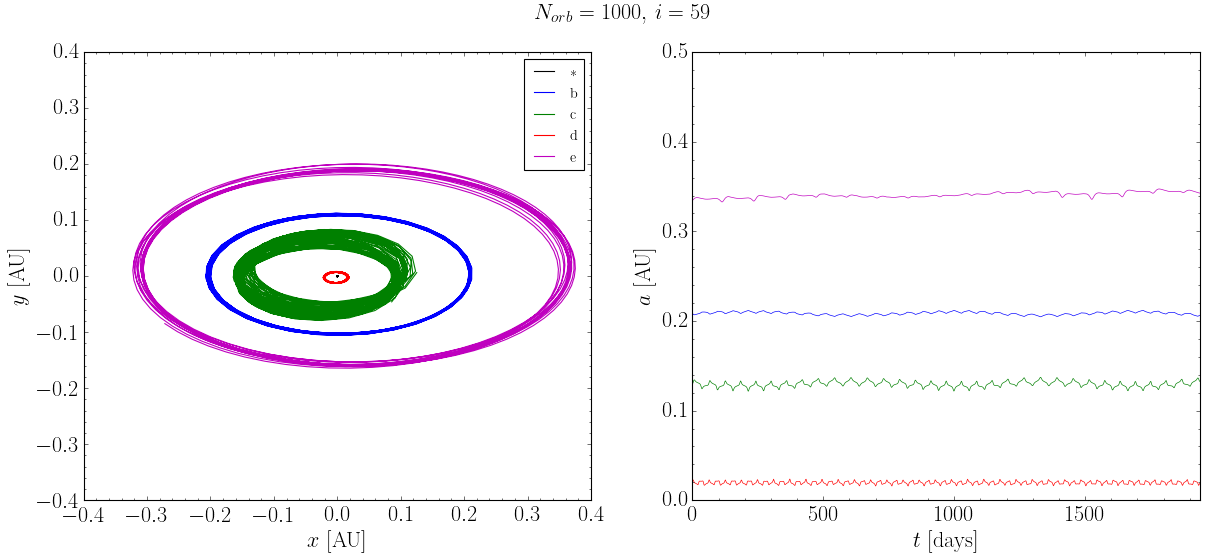

In [564]:
inc_d = 59
torb = P[2]
Norb = 1000
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)

x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=False)

plot_orbit(x_sim, y_sim, a_sim, times, save=False)


100%|██████████| 4/4 [00:13<00:00,  3.47s/it]


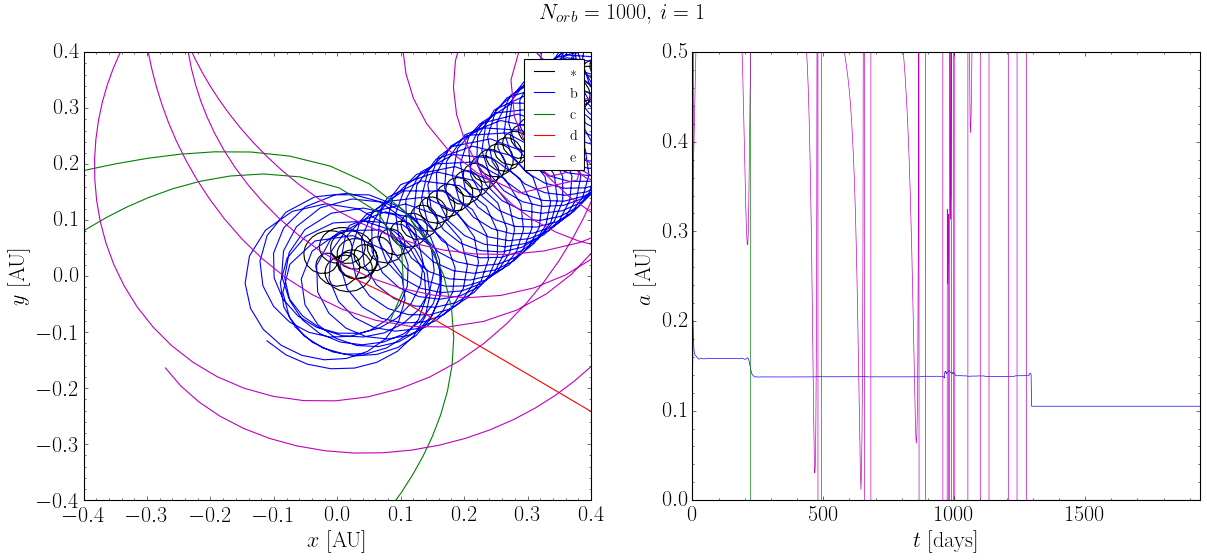

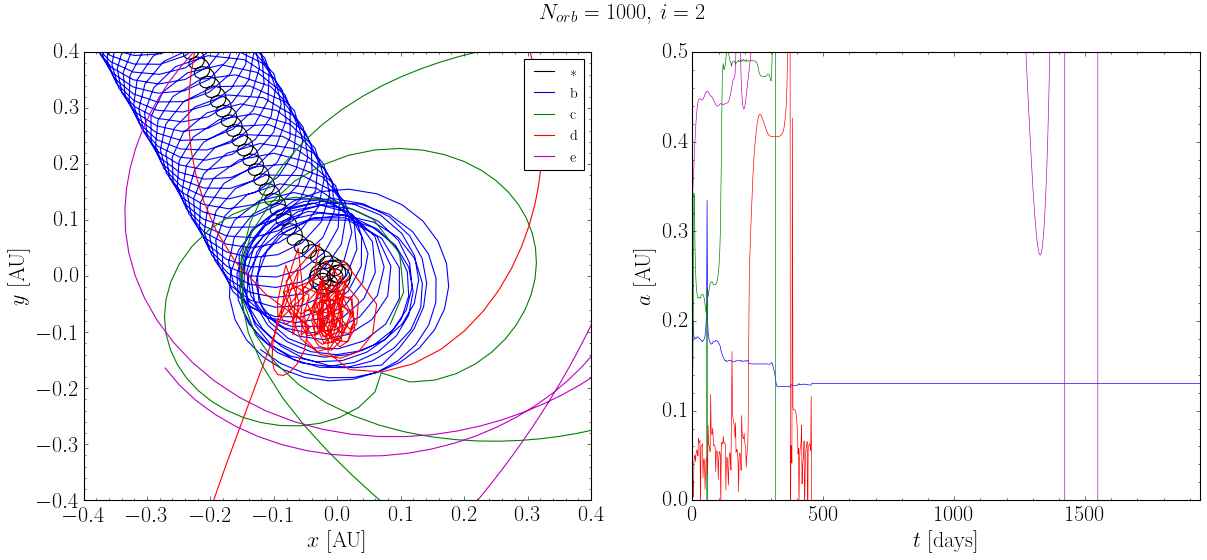

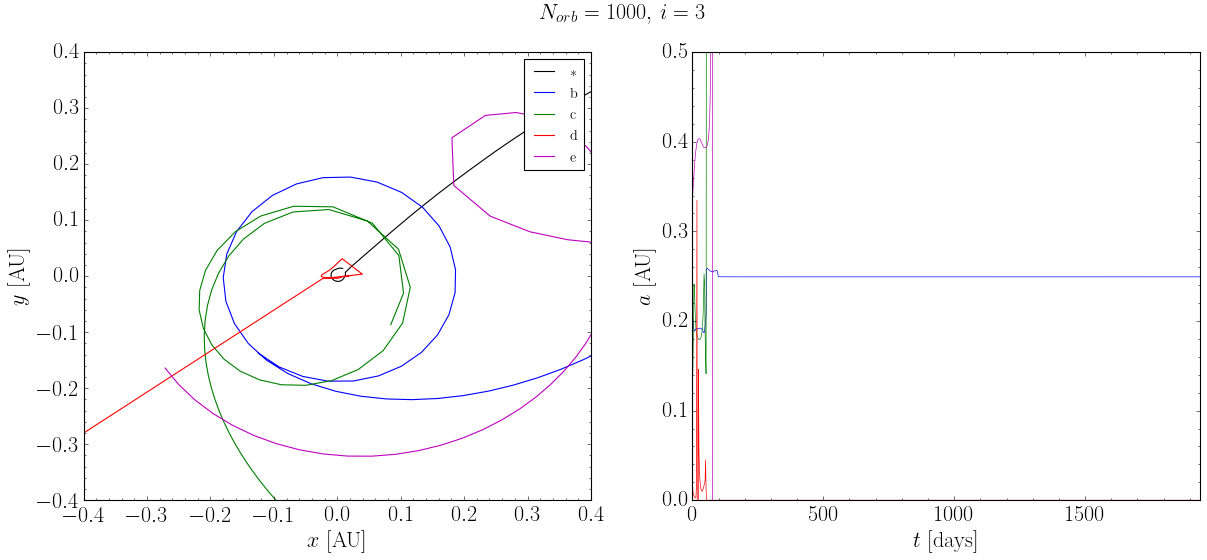

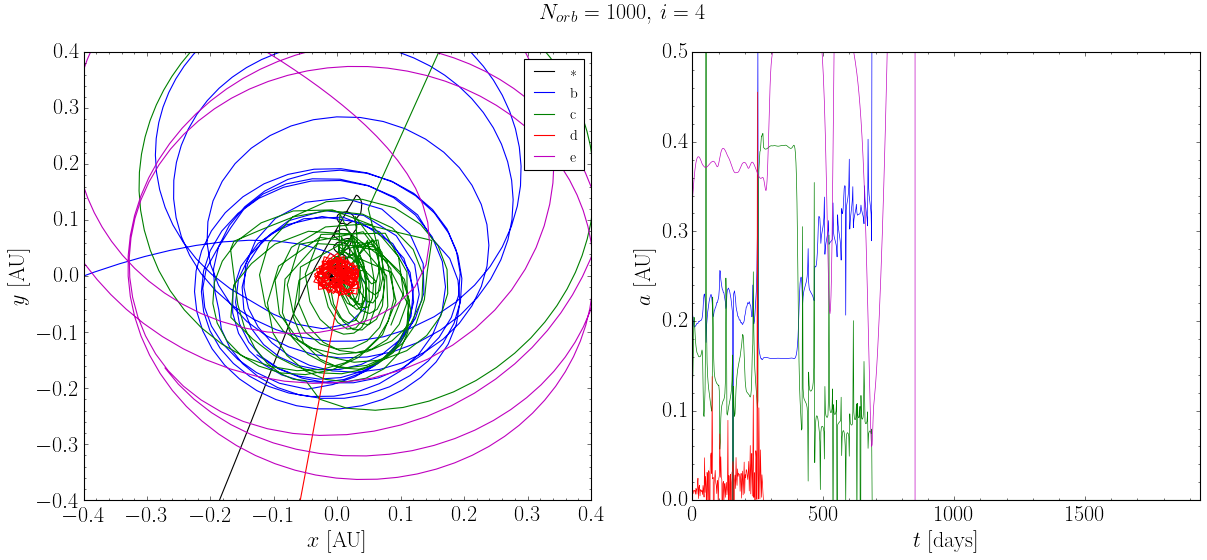

In [47]:
# ========================
# Calculate orbits for a grid of inclinations
# ========================

inc_rng = [1,50]
torb = P[2]
Norb = 1000
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)
test_inc = np.arange(inc_rng[0], inc_rng[1], 1)

for inc_d in tqdm.tqdm(test_inc):
    x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=True)
    plot_orbit(x_sim, y_sim, a_sim, times, show=False);

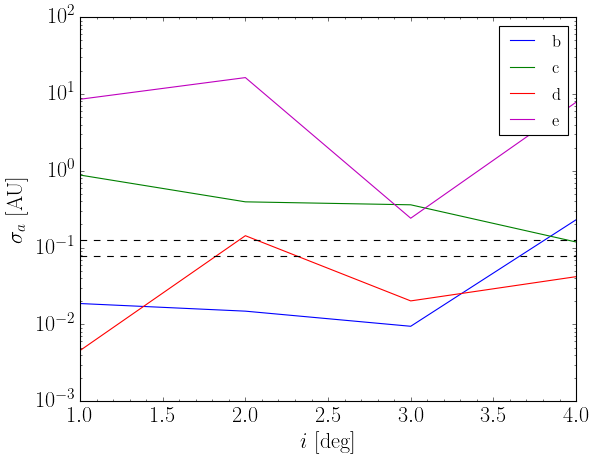

In [51]:
# ========================
# Load semi-major axis saved results
# ========================

a_std = []
for inc_d in test_inc:
    a_sim = np.load(f'results/N1000_i{inc_d}_a.npy')
    a_std.append(np.std(a_sim, axis=0))
a_std = np.array(a_std).T

# ========================
# Plot standard deviation of semi-major axis vs inclination
# ========================

for k in range(1,N+1):
    plt.plot(test_inc, a_std[k], color=colors[k], label=f'{names[k]}')
plt.axhline(min(np.diff(np.sort(a))), color='k', linestyle='--')
plt.axhline(max(np.diff(np.sort(a))), color='k', linestyle='--')
plt.ylabel(r'$\sigma_{a}$ [AU]')
plt.xlabel(r'$i$ [deg]')
# plt.ylim(0,.5)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=15)
plt.minorticks_on()
plt.savefig('plots/std_a.png')
plt.show()

In [592]:
m*np.sin(i)/np.sin(12*math.pi/180)

array([6.65267941e-03, 2.08795203e-03, 6.13931568e-05, 1.34480248e-04])

In [593]:
m*np.sin(i)/np.sin(90*math.pi/180)

array([1.38316982e-03, 4.34109636e-04, 1.27643550e-05, 2.79600158e-05])

In [594]:
m

array([2.17227464e-03, 6.81771202e-04, 2.00464789e-05, 4.39113348e-05])

**Problem 3:** Compute the radial velocity of the star, and then fit this RV with four Keplerian
orbits. How big are the residuals? How does this compare to typical RV errors?

In [7]:
def g(E, e_, M_):
    """
    Return error on solution to Kepler's equation
    """
    return E - e_*np.sin(E) - M_


def E_sol(e_, M_, error=2e-16, max_iter=1e3):
    """
    Solve for E using Newton's method
    """
    # initial guess
    E = M_ + .85*e_*np.sign(np.sin(M_))

    j = 0
    # iterate until the specified precision is reached up to limited # of iterations
    while (abs(g(E, e_, M_)).any() > error) & (j < max_iter):
        E -= g(E, e_, M_)/(1 - e_*np.cos(E))
        j += 1

    return E


def rv(t, K_, P_, tp_, e_, pomega_, gamma_):
    """
    Radial velocity model of the star

    K 		: rv amplitude (km/s)
    P 		: peroid (days)
    tp 		: time of periastron (days)
    e 		: eccentricity
    pomega 	: pericenter angle (rad)
    gamma 	: velocity of center of mass
    """
    # K = (2*math.pi*G)/(P*(1-e**2)**(3/2))**(1/3) * Mp*np.sin(i)/(Ms + Mp)**(2/3)

    Marr = 2*math.pi/P_ * (t - tp_)
    E = E_sol(e_, Marr)

    f = 2*np.arctan(((1+e_)/(1-e_))**.5 * np.tan(E/2))

    vz_ = K_*np.cos(f)*np.cos(pomega_) - K_*np.sin(f)*np.sin(pomega_) + gamma_ + K_*e_*np.cos(pomega_)

    return vz_

In [39]:
inc_d = 59
torb = P[2]
Norb = 10
Noutputs = 1000
times = np.linspace(0, Norb*torb, Noutputs)

x_sim, y_sim, vz_sim, a_sim, w_sim, e_sim = calculate_orbit(torb, inc_d, times, save=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


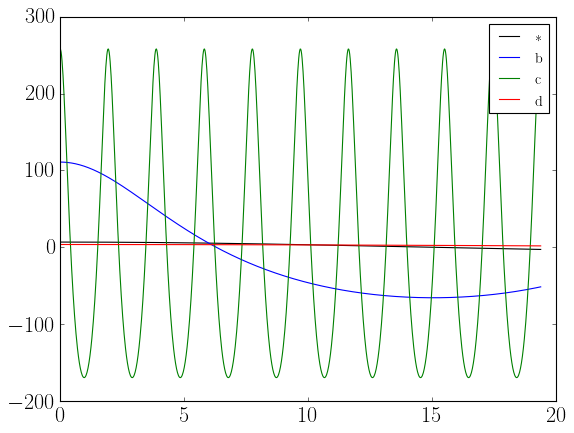

In [43]:
pomega_init = np.ones(N)*0
gamma_init  = np.zeros(N)
tp = np.array([0,0,0,0])

# =================================

planet_rvs = []
for k in range(4):
    vz_planet = rv(times, K[k], P[k], tp[k], e[k], pomega_init[k], gamma_init[k])
    planet_rvs.append(vz_planet)
    plt.plot(times, vz_planet, color=colors[k], label=f'{names[k]}')
plt.legend(loc='upper right', fontsize=13);

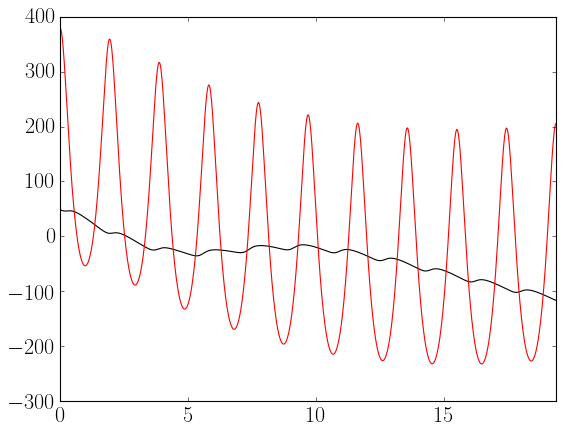

In [41]:
star_rv = np.sum(np.array(planet_rvs), axis=0)
star_rv_sim = (vz_sim.T[0] * u.AU/u.day).to(u.m/u.s).value

plt.plot(times, star_rv_sim, color='k')
plt.plot(times, star_rv, color='r')
plt.xlim(0, max(times))
plt.show()

In [29]:
from astropy.timeseries import BoxLeastSquares
model = BoxLeastSquares(times * u.day, star_rv)

periods = np.linspace(1, 150, 1e5) * u.day
periodogram = model.power(periods, 0.2)

In [30]:
periodogram.power

array([  889.88294796, 13677.52509087,  2404.20604607, ...,
       28138.1597501 , 28138.1597501 , 29579.42678385])

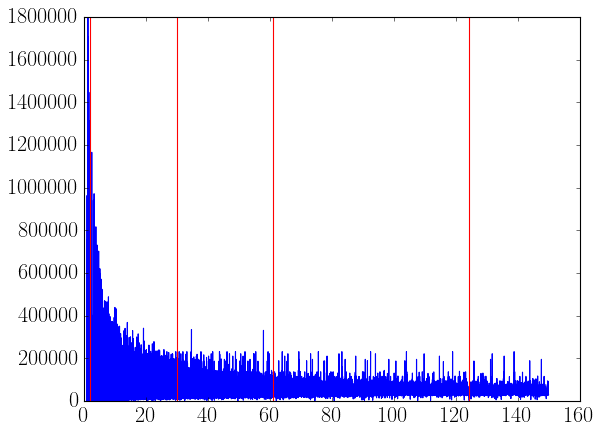

best period: 1.4157141571415714 d


In [31]:
plt.plot(periodogram.period, periodogram.power)
for pp in P:
    plt.axvline(pp, color='r')
plt.show()
print('best period:', periodogram.period[np.argmax(periodogram.power)])

**Problem 4:** Look at REBOUND TTV example. Make a plot of the TTVs of GJ 876 c over 4
years (assuming edge-on, so that planet would transit). Measure amplitude and
period of the sinusoidal variation component. How does it change if you vary the
mass of GJ 876 b downward and upward by a factor of 2?